In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

import numpy as np
from keras.datasets import cifar10
from random import randrange
import time
import pickle

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)


In [3]:
# print (x_train.shape)
# print (y_train.shape)

# all_aug_x = pickle.load(open('aug_image/x_images.p','rb'))
# all_aug_y = pickle.load(open('aug_image/y_images.p','rb'))


# x_train = np.concatenate([x_train,all_aug_x])
# y_train = np.concatenate([y_train,all_aug_y])

# print (x_train.shape)
# print (y_train.shape)

Визуализируем классы

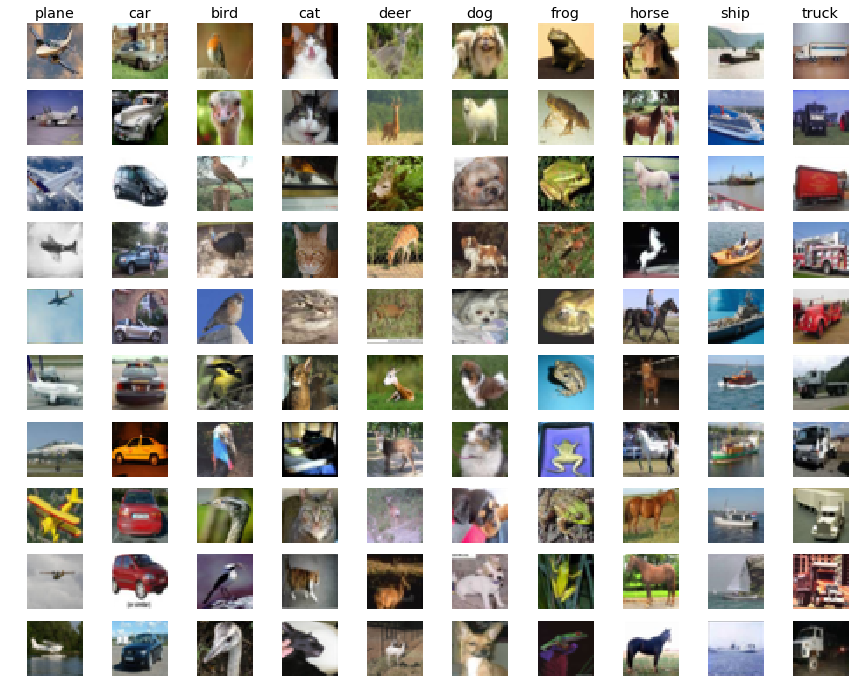

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

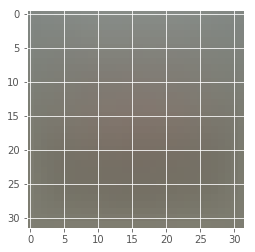

In [5]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [6]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

Пожалуйста, ознакомьтесь с другими возможностями, которые предоставляет tf для описания модели. 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/BatchNormalization

Теперь мы можем двигаться дальше и протестировать получившуюся модель. Для этого реализуем тренировочный цикл


Принимаются работы с точностью **не менее 84%**. 

Полезные ссылки:
  - [ResNet](https://arxiv.org/abs/1512.03385).
  - [DenseNet](https://arxiv.org/abs/1608.06993).
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

Напишите ваш код под текстом задания

### My network

In [8]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator


In [9]:
## https://gist.github.com/vertix/d2b1256003e9ffca8e7fc36ba1ba4eb3

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [10]:
import math

def augment(images, labels,
            resize=None, # (width, height) tuple or None
            horizontal_flip=False,
            vertical_flip=False,
            rotate=0, # Maximum rotation angle in degrees
            crop_probability=0, # How often we do crops
            crop_min_percent=0.6, # Minimum linear dimension of a crop
            crop_max_percent=1.,  # Maximum linear dimension of a crop
            mixup=0):  # Mixup coeffecient, see https://arxiv.org/abs/1710.09412.pdf
  if resize is not None:
    images = tf.image.resize_bilinear(images, resize)
  
  # My experiments showed that casting on GPU improves training performance
  if images.dtype != tf.float32:
    images = tf.image.convert_image_dtype(images, dtype=tf.float32)
    images = tf.subtract(images, 0.5)
    images = tf.multiply(images, 2.0)
  labels = tf.to_float(labels)

  with tf.name_scope('augmentation'):
    shp = tf.shape(images)
    batch_size, height, width = shp[0], shp[1], shp[2]
    width = tf.cast(width, tf.float32)
    height = tf.cast(height, tf.float32)

    # The list of affine transformations that our image will go under.
    # Every element is Nx8 tensor, where N is a batch size.
    transforms = []
    identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
    if horizontal_flip:
      coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
      flip_transform = tf.convert_to_tensor(
          [-1., 0., width, 0., 1., 0., 0., 0.], dtype=tf.float32)
      transforms.append(
          tf.where(coin,
                   tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),
                   tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

    if vertical_flip:
      coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
      flip_transform = tf.convert_to_tensor(
          [1, 0, 0, 0, -1, height, 0, 0], dtype=tf.float32)
      transforms.append(
          tf.where(coin,
                   tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),
                   tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

    if rotate > 0:
      angle_rad = rotate / 180 * math.pi
      angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
      transforms.append(
          tf.contrib.image.angles_to_projective_transforms(
              angles, height, width))

    if crop_probability > 0:
      crop_pct = tf.random_uniform([batch_size], crop_min_percent,
                                   crop_max_percent)
      left = tf.random_uniform([batch_size], 0, width * (1 - crop_pct))
      top = tf.random_uniform([batch_size], 0, height * (1 - crop_pct))
      crop_transform = tf.stack([
          crop_pct,
          tf.zeros([batch_size]), top,
          tf.zeros([batch_size]), crop_pct, left,
          tf.zeros([batch_size]),
          tf.zeros([batch_size])
      ], 1)

      coin = tf.less(
          tf.random_uniform([batch_size], 0, 1.0), crop_probability)
      transforms.append(
          tf.where(coin, crop_transform,
                   tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

    if transforms:
      images = tf.contrib.image.transform(
          images,
          tf.contrib.image.compose_transforms(*transforms),
          interpolation='BILINEAR') # or 'NEAREST'

    def cshift(values): # Circular shift in batch dimension
      return tf.concat([values[-1:, ...], values[:-1, ...]], 0)

    if mixup > 0:
      mixup = 1.0 * mixup # Convert to float, as tf.distributions.Beta requires floats.
      beta = tf.distributions.Beta(mixup, mixup)
      lam = beta.sample(batch_size)
      ll = tf.expand_dims(tf.expand_dims(tf.expand_dims(lam, -1), -1), -1)
      images = ll * images + (1 - ll) * cshift(images)
      labels = lam * labels + (1 - lam) * cshift(labels)

  return images, labels


In [11]:
## https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
##




def my_vgg16():
    # placeholder'ы это точки входа, можно восприпимать их, как аргументы функции, описываемой графом
     
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    
    x, _ = augment(x, y,
            resize=None, # (width, height) tuple or None
            horizontal_flip=True,
            vertical_flip=True,
            rotate=15, # Maximum rotation angle in degrees
            crop_probability=0.1, # How often we do crops
            crop_min_percent=0.0, # Minimum linear dimension of a crop
            crop_max_percent=0.3,  # Maximum linear dimension of a crop
            mixup=0)
    
    is_training = tf.placeholder(tf.bool)
    l2_reg = tf.placeholder(tf.float32)

    USE_L2_REG = 'L2_REG'
    
    #variable scope задаёт префикс для всех элементов внутри него
    #Это позволяет огранизовавывать структуру графа и вашего кода
    with tf.variable_scope("conv_1"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv1", shape=[3, 3, 3, 64])
        bconv = tf.get_variable("bconv1", shape=[64])
        
        a1 = tf.nn.conv2d(x, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        nn = tf.nn.dropout(nn, keep_prob=0.7)
        
        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)
        

    with tf.variable_scope("conv_2"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv2", shape=[3, 3, 64, 64])
        bconv = tf.get_variable("bconv2", shape=[64])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)
        
        
    with tf.variable_scope("max_pool_1"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,1,1,1],padding = 'SAME') ## (?, 32, 32, 64)
    
    
    with tf.variable_scope("conv_3"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv3", shape=[3, 3, 64, 128])
        bconv = tf.get_variable("bconv3", shape=[128])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        nn = tf.nn.dropout(nn, keep_prob=0.7)

        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)
        
    with tf.variable_scope("conv_4"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv4", shape=[3, 3, 128, 128])
        bconv = tf.get_variable("bconv4", shape=[128])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)
    
    with tf.variable_scope("max_pool_2"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,1,1,1],padding = 'SAME') ## (?, 32, 32, 128)
        
        
    with tf.variable_scope("conv_5"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv3", shape=[3, 3, 128, 256])
        bconv = tf.get_variable("bconv3", shape=[256])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        nn = tf.nn.dropout(nn, keep_prob=0.7)

        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)        
        
        
    with tf.variable_scope("conv_6"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv4", shape=[3, 3, 256, 256])
        bconv = tf.get_variable("bconv4", shape=[256])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)        
    
    with tf.variable_scope("max_pool_3"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID') ## (?, 16, 16, 256)
        
    with tf.variable_scope("conv_7"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv3", shape=[3, 3, 256, 512])
        bconv = tf.get_variable("bconv3", shape=[512])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        nn = tf.nn.dropout(nn, keep_prob=0.7)

        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)        
                
    with tf.variable_scope("conv_8"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv = tf.get_variable("Wconv4", shape=[3, 3, 512, 512])
        bconv = tf.get_variable("bconv4", shape=[512])
        
        a1 = tf.nn.conv2d(nn, Wconv, strides=[1,1,1,1], padding='SAME') + bconv
        a2 = tf.layers.batch_normalization(a1, training=is_training)                            
        nn = tf.nn.relu(a2)
        
        tf.add_to_collection(USE_L2_REG, Wconv)
        tf.add_to_collection(USE_L2_REG, bconv)        
    
    with tf.variable_scope("max_pool_4"):
        nn = tf.nn.max_pool(nn,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID') ## (?, 8, 8, 512)
    
        nn = tf.nn.dropout(nn, keep_prob=0.7)

    #добавляем полносвязный слой
    with tf.variable_scope("dense_layer_1"):
        size = 8*8*512
        W1 = tf.get_variable("W1", shape=[size, 4096])
        b1 = tf.get_variable("b1", shape=[4096])
        
        nn = tf.reshape(nn,[-1,size])
        nn = tf.matmul(nn,W1) + b1  
        
        nn = tf.layers.batch_normalization(nn, training=is_training)                    
    
        nn = tf.nn.relu(nn)
        nn = tf.nn.dropout(nn, keep_prob=0.5)
        
        tf.add_to_collection(USE_L2_REG, W1)
        tf.add_to_collection(USE_L2_REG, b1)        
        
        
    with tf.variable_scope("dense_layer_2"):
        W1 = tf.get_variable("W1", shape=[4096, 4096])
        b1 = tf.get_variable("b1", shape=[4096])
        nn = tf.matmul(nn,W1) + b1
        
        nn = tf.layers.batch_normalization(nn, training=is_training)      
        
        nn = tf.nn.relu(nn)
        nn = tf.nn.dropout(nn, keep_prob=0.5)

        tf.add_to_collection(USE_L2_REG, W1)
        tf.add_to_collection(USE_L2_REG, b1)             
        
        
    with tf.variable_scope("dense_layer_3"):
        W1 = tf.get_variable("W1", shape=[4096, 10])
        b1 = tf.get_variable("b1", shape=[10])
        
        y_out = tf.matmul(nn,W1) + b1

        tf.add_to_collection(USE_L2_REG, W1)
        tf.add_to_collection(USE_L2_REG, b1)     
        
    ## l2 regularization
    L2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.get_collection(USE_L2_REG)]) * l2_reg
        
    # y_out -- это вектор оценок, которые генерирует модель. Теперь определим функцию потерь
    total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
    mean_loss = tf.reduce_mean(total_loss) + L2_loss
    
    correct_prediction = tf.equal(tf.argmax(y_out,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar('mean_loss', mean_loss)
    tf.summary.scalar('accuracy', accuracy)
            
    #Возвращаем те узлы графа, которые нам понадобятся в дальнейшем.
    #(x,y) это входы графа, а (y_out, mean_loss) выходы, которые представляют для нас интерес
    return (x,y,is_training,l2_reg), (y_out, mean_loss, accuracy)

In [12]:
def training_loop(session, model_inputs, model_outputs, train_step, 
                  epochs=10, batch_size=64):
    
    train_writer = tf.summary.FileWriter('tensorboard/train',session.graph)
    val_writer = tf.summary.FileWriter('tensorboard/val')

    #создаём индекс по всем объектам
    index = np.arange(len(x_train))
    
    #перемешиваем его
    np.random.shuffle(index)
    
    #разбиваем на батчи
    num_batches = int(len(index) / batch_size)
    batch_indexes = np.array_split(index, num_batches)
    
    #аналогично для теста
    index_test = np.arange(len(x_test))
    np.random.shuffle(index_test)
    num_batches_test = int(len(index_test) / batch_size)
    batch_indexes_test = np.array_split(index_test, num_batches_test)
    
    #аналогично для validation
    index_val = np.arange(len(x_val))
    np.random.shuffle(index_val)
    num_batches_val = int(len(index_val) / batch_size)
    batch_indexes_val = np.array_split(index_val, num_batches_val)
    
    x,y,is_training,l2_reg,learning_rate = model_inputs
    y_out, mean_loss, accuracy = model_outputs
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    
    eraser = get_random_eraser(p=0.3, v_l=0, v_h=1, s_l=0.02, s_h=0.4, pixel_level=True)
    
    def cosine_decay(learning_rate,global_step,decay_steps,alpha=0.0):
        global_step = min(global_step, decay_steps)
        cosine_decay = 0.5 * (1 + np.cos(np.pi * global_step / decay_steps))
        decayed = (1 - alpha) * cosine_decay + alpha
        decayed_learning_rate = learning_rate * decayed
        return decayed_learning_rate
    
    def train(x_values, y_values, batch_indexes, epoch):
        train_loses = []
        for i, batch_index in enumerate(batch_indexes):
            
#             lr = 0.0001/10**(epoch)
            lr = cosine_decay(0.0001,global_step = epoch % 30,decay_steps = 30, alpha = 0.001)

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
#             x_batch = [datagen.random_transform(img) for img in x_values[batch_index]]
                
            x_batch = [eraser(img) for img in x_values[batch_index]]
        
            feed_dict = {x: x_batch,
                         y: y_values[batch_index],
                        is_training:True,
                        l2_reg: 0.001,
                        learning_rate:lr}

            #Здесь происходит непоследственный вызов модели
            #Обратите внимание, что мы передаём 
                      
            summary, scores, loss, acc, _ = session.run([merged,y_out, mean_loss, accuracy, train_step],feed_dict=feed_dict)

            train_loses.append(loss)
            print(f'iteration {i}, train loss: {loss:.3}, accuracy: {acc:.3}', end='\r')
            
            train_writer.add_summary(summary, epoch * num_batches+i)

        return train_loses
        
    def evaluate(x_values, y_values, batch_indexes, epoch):
        test_loses = []
        test_accuracy = []

        i_to_save = np.random.randint(0,high=len(batch_indexes),size=1)[0]
        for batch_index in batch_indexes:

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index],
                        is_training:False,
                        l2_reg : 0}
            
            #Здесь происходит непоследственный вызов модели
            
            summary, loss, acc = session.run([merged,mean_loss, accuracy],feed_dict=feed_dict)
                             
            i_to_save = i_to_save - 1
            
            test_loses.append(loss)
            test_accuracy.append(acc)

        return test_loses, test_accuracy
    
        
    # цикл по эпохам
    for e in range(epochs):
        print(f'Epoch {e}:')
        train_loses = train(x_train, y_train, batch_indexes, e)
        val_loses, val_accuracy = evaluate(x_val, y_val, batch_indexes_val, e)
        print(f'train loss: {np.mean(train_loses):.3}, val loss: {np.mean(val_loses):.3}, accuracy: {np.mean(val_accuracy):.3}')
        
        save_path = saver.save(session, "checkpoints/model_vgg16_v2.ckpt")
            
    print('================================================')
    print('Test set results:')
    test_loses, test_accuracy = evaluate(x_test, y_test, batch_indexes_test,e)
    print(f'test loss: {np.mean(test_loses):.3}, accuracy: {np.mean(test_accuracy):.3}')

In [13]:
#Перед вызовом функции очистим память от графов других моделей (актуально если вы вызываете эту ячейку повторно)
tf.reset_default_graph()
(x,y,is_training,l2_reg), (y_out, mean_loss, accuracy) = my_vgg16()

merged = tf.summary.merge_all()
saver = tf.train.Saver()


#Теперь зададим алгоритм оптимизации
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate) 
#train_step -- специальный служебный узел в графе, отвечающий за обратный проход


update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    
    gvs = optimizer.compute_gradients(mean_loss)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_step = optimizer.apply_gradients(capped_gvs)

#     train_step = optimizer.minimize(mean_loss) 

In [14]:

# создаём сессию. Сессия -- это среда, в которой выполняются вычисления
with tf.Session() as sess:
        
    #мы можем явно указать устройство
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        #инициализируем веса, в этот момент происходит выделение памяти
        sess.run(tf.global_variables_initializer())
        
        #запускаем тренировку
        training_loop(sess, model_inputs=(x,y,is_training, l2_reg, learning_rate), 
                      model_outputs=(y_out, mean_loss, accuracy), 
                      train_step=train_step, epochs=89)

Epoch 0:
train loss: 5.26, val loss: 0.263, accuracy: 0.429
Epoch 1:
train loss: 2.46, val loss: 0.237, accuracy: 0.511
Epoch 2:
train loss: 1.23, val loss: 0.198, accuracy: 0.68
Epoch 3:
train loss: 0.766, val loss: 0.182, accuracy: 0.636
Epoch 4:
train loss: 0.562, val loss: 0.184, accuracy: 0.654
Epoch 5:
train loss: 0.465, val loss: 0.155, accuracy: 0.656
Epoch 6:
train loss: 0.41, val loss: 0.118, accuracy: 0.754
Epoch 7:
train loss: 0.373, val loss: 0.129, accuracy: 0.753
Epoch 8:
train loss: 0.345, val loss: 0.139, accuracy: 0.725
Epoch 9:
train loss: 0.326, val loss: 0.147, accuracy: 0.719
Epoch 10:
train loss: 0.312, val loss: 0.13, accuracy: 0.745
Epoch 11:
train loss: 0.293, val loss: 0.12, accuracy: 0.732
Epoch 12:
train loss: 0.278, val loss: 0.123, accuracy: 0.752
Epoch 13:
train loss: 0.267, val loss: 0.0995, accuracy: 0.788
Epoch 14:
train loss: 0.254, val loss: 0.115, accuracy: 0.755
Epoch 15:
train loss: 0.24, val loss: 0.105, accuracy: 0.763
Epoch 16:
train loss: 0.2

### Make prediction on test set

In [15]:
def test_eval(session, model_input, model_output, x_test,y_test, batch_size = 64):
    
    x, y , is_training, l2_reg = model_input
    y_out = model_output

    #аналогично для теста
    index_test = np.arange(len(x_test))
    num_batches_test = int(len(index_test) / batch_size)
    batch_indexes_test = np.array_split(index_test, num_batches_test)
    
    y_pred = []

    for batch_index in batch_indexes_test:

        #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
        feed_dict = {x: x_test[batch_index],
                     y: y_test[batch_index],
                    is_training:False,
                    l2_reg : 0}

        #Здесь происходит непоследственный вызов модели

        y_pred_batch = session.run([y_out],feed_dict=feed_dict)

        y_pred.append(y_pred_batch[0])
        
    y_pred = np.concatenate(y_pred)
    y_pred = [np.argmax(x) for x in y_pred]
    return y_pred

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "checkpoints/model_vgg16_v2.ckpt")
    y_pred = test_eval(sess,
                       model_input = (x, y , is_training, l2_reg),
                       model_output = y_out,
                       x_test = x_test, y_test = y_test)

INFO:tensorflow:Restoring parameters from checkpoints/model_vgg16_v2.ckpt


In [16]:
to_file = np.stack([np.arange(len(y_pred)),y_pred]).T
np.savetxt("pred_vg16.txt",to_file,fmt='%.d',header='id,label',delimiter=",",comments="")